In [1]:
!pip install transformers datasets evaluate scikit-learn --quiet

import re
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    Trainer, TrainingArguments,
    DataCollatorWithPadding,
    logging
)
import evaluate
import warnings

warnings.filterwarnings("ignore")
logging.set_verbosity_error()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00
Using device: cuda


In [2]:
dataset = load_dataset("imdb")
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

print(f"Training samples: {len(train_df)}")
print(f"Test samples    : {len(test_df)}")
print("\nSample review:\n", train_df.iloc[0]["text"][:300])
print("Label:", train_df.iloc[0]["label"])


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Training samples: 25000
Test samples    : 25000

Sample review:
 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h
Label: 0


In [3]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

train_df["cleaned_text"] = train_df["text"].apply(clean_text)
test_df["cleaned_text"] = test_df["text"].apply(clean_text)


In [5]:
from torch.utils.data import Dataset

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class IMDbDataset(Dataset):
    def __init__(self, df):
        self.encodings = tokenizer(
            df["cleaned_text"].tolist(),
            truncation=True,
            padding=True,
            max_length=128
        )
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = IMDbDataset(train_df)
test_dataset = IMDbDataset(test_df)


In [6]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [7]:
import transformers
print(transformers.__version__)

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir="./logs",
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    seed=42,
    save_total_limit=1,
)


4.54.1


In [8]:
data_collator = DataCollatorWithPadding(tokenizer)
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    return {"accuracy": acc["accuracy"]}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


In [9]:
print("Training model...")
trainer.train()

Training model...
{'loss': 0.4176, 'grad_norm': 15.568465232849121, 'learning_rate': 4.201855406269994e-05, 'epoch': 0.3198976327575176}
{'loss': 0.3358, 'grad_norm': 5.0408172607421875, 'learning_rate': 3.4021113243761995e-05, 'epoch': 0.6397952655150352}
{'loss': 0.3022, 'grad_norm': 21.57855224609375, 'learning_rate': 2.602367242482406e-05, 'epoch': 0.9596928982725528}
{'eval_loss': 0.31836801767349243, 'eval_accuracy': 0.87704, 'eval_runtime': 172.9507, 'eval_samples_per_second': 144.55, 'eval_steps_per_second': 4.522, 'epoch': 1.0}
{'loss': 0.1913, 'grad_norm': 7.90702486038208, 'learning_rate': 1.8026231605886118e-05, 'epoch': 1.2795905310300704}
{'loss': 0.1698, 'grad_norm': 20.572275161743164, 'learning_rate': 1.0028790786948176e-05, 'epoch': 1.599488163787588}
{'loss': 0.1535, 'grad_norm': 21.910276412963867, 'learning_rate': 2.0313499680102367e-06, 'epoch': 1.9193857965451055}
{'eval_loss': 0.3807937502861023, 'eval_accuracy': 0.89544, 'eval_runtime': 172.9942, 'eval_samples_

TrainOutput(global_step=3126, training_loss=0.25932503295722714, metrics={'train_runtime': 1529.7018, 'train_samples_per_second': 32.686, 'train_steps_per_second': 2.044, 'train_loss': 0.25932503295722714, 'epoch': 2.0})

In [11]:
print("Evaluating on test set...")
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

Evaluating on test set...
{'eval_loss': 0.3807937502861023, 'eval_accuracy': 0.89544, 'eval_runtime': 172.7721, 'eval_samples_per_second': 144.699, 'eval_steps_per_second': 4.526, 'epoch': 2.0}
Evaluation results: {'eval_loss': 0.3807937502861023, 'eval_accuracy': 0.89544, 'eval_runtime': 172.7721, 'eval_samples_per_second': 144.699, 'eval_steps_per_second': 4.526, 'epoch': 2.0}


In [12]:
print("Generating predictions and classification report...")
pred_output = trainer.predict(test_dataset)
preds = np.argmax(pred_output.predictions, axis=1)
labels = pred_output.label_ids

print("\nClassification Report:\n")
print(classification_report(labels, preds, target_names=["negative", "positive"]))


Generating predictions and classification report...

Classification Report:

              precision    recall  f1-score   support

    negative       0.90      0.89      0.89     12500
    positive       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



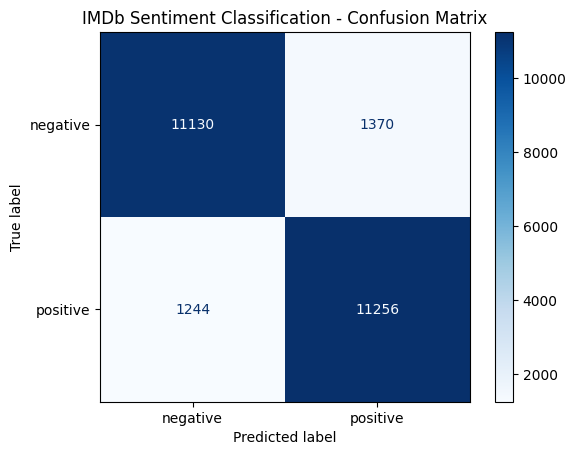

In [13]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("IMDb Sentiment Classification - Confusion Matrix")
plt.show()


In [14]:
compare_df = pd.DataFrame({
    "text": test_df["cleaned_text"],
    "actual_label": labels,
    "predicted_label": preds
})

print("\nSample Predictions:")
print(compare_df.sample(10).to_string(index=False))



Sample Predictions:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   